In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import os
import sys
import time

import numpy as np
import pandas as pd
import tensorflow as tf

import agents
import tetris_api
import tf_rl_utils

env = tetris_api.PyTetrisEnv()
env.reset()
env.render()


|              1 1   |
|              1 1   |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
______________________


In [16]:
a = np.array(1)
a.shape == ()


True

In [8]:
state = env.reset()
print(env.game.pretty_print_board(state))



|              1 1   |
|              1 1   |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
______________________


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import os
import sys
import time

import numpy as np
import pandas as pd
import tensorflow as tf

import agents
import tetris_api
import tf_rl_utils


from collections import OrderedDict
from IPython.display import clear_output
from matplotlib import pyplot as plt

tf.reset_default_graph()

ACTIONS = {3: 'up', 2: 'right', 1: 'left', 0: 'down'}

# tetris
num_cols = 4
num_rows = 16
RESTORE_MODEL = False
# Clear TensorBoard.
!rm -r models/tetris/tensorboard


# utilize prior states
n_prior_states = 5

# learning params
GAMMA = 0.99
LR = 1e-2
MAX_EP = 99999 # how many steps to take
update_frequency = 25 # after how many games to update model

# input, actions, rewards
n_inputs = num_cols*num_rows*n_prior_states
x = tf.placeholder(tf.float32, shape=[None, n_inputs])

fake_labels = tf.placeholder(tf.int32)
actions = tf.placeholder(tf.int32, shape=[None])
rewards = tf.placeholder(tf.float32, shape=[None])  # For a single game.

games_rewards = tf.placeholder(tf.float32, shape=[None])   # Mean of sum of rewards across several games.
mean_reward = tf.reduce_mean(games_rewards)

####### fully connect NN #######

#TODO: log these values so we can see how everything is doing.
# layers
n_hidden1 = 100
n_hidden2 = 30
fully_connected_tetris = agents.FullyConnected(tf.get_default_graph(), x, fake_labels, 
                                               [n_hidden1, n_hidden2, 4], LR)
y = fully_connected_tetris.logits

    
################################

# build output
output = tf.nn.softmax(y)

def pg_move(sess):
    def _move(nn_input):
        return sess.run(output, feed_dict={x: [nn_input]})[0]
    return _move


# get prob for chosen action
# first need to figure out indices of all of the chose actions
# from the flattened array
action_indices = (tf.range(0, tf.shape(y)[0]) * tf.shape(y)[1]) + actions
prob_for_picked_actions = tf.gather(tf.reshape(output, [-1]), action_indices)

# loss function
cross_entropy = -tf.reduce_mean(tf.log(prob_for_picked_actions) * rewards)
train_step = tf.train.AdamOptimizer(LR).minimize(cross_entropy)

# Save model results.
saver = tf.train.Saver()
model = os.path.join(os.path.join(os.getcwd(), 'models', 'tetris', 'fully_connected.ckpt'))

# Tensorboard.
reward_summary = tf.summary.scalar('avg_reward', mean_reward)
xent_summary = tf.summary.scalar('xent', cross_entropy)
tf_rl_utils.variable_summaries(fully_connected_tetris.hidden1, 'hidden_1')
tf_rl_utils.variable_summaries(fully_connected_tetris.hidden1, 'hidden_2')


merged = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(os.path.join('models', 'tetris', 'tensorboard') , tf.get_default_graph())

env = tetris_api.PyTetrisEnv()
all_ep_history = []
game_num = 0

# tf stuff init 
with tf.Session() as sess:
    # initialize variables
    sess.run(tf.global_variables_initializer())
    if RESTORE_MODEL:
        saver.restore(sess, save_path=model)
    _games_rewards = []
    
       
    while True:
            done = False
            ep_history, meta_results = tf_rl_utils.play_game(env, pg_move(sess), MAX_EP, num_rows, num_cols,
                                                             n_prior_states)
            game_num += 1
            done = True
            start = time.time()
            if done:
                ep_history = np.array(ep_history)
                r = tf_rl_utils.discount_rewards(ep_history[:, 2], gamma=GAMMA)
                ep_history[:, 2] = r
                all_ep_history.append(ep_history)
                _games_rewards.append(np.sum(r))
                ep_history = []

                its_time_to_update_weights = ((game_num % update_frequency) == 0 and (game_num != 0))
                if its_time_to_update_weights:
#                     clear_output()
#                     print("n moves: {}, to play batch: {}".format(batch_num_moves, time.time() - batch_start_time))
#                     print("game_num :", game_num, ', mean reward: {:2.2f}'.format(np.mean(games_rewards[game_num-update_frequency:game_num])))
                    batch_start_time = time.time()
                    weight_update_start = time.time()
                    all_ep_history = np.vstack(all_ep_history)
                    feed_dict = {rewards: all_ep_history[:, 2],
                                 actions: all_ep_history[:, 1],
                                 x: np.vstack(all_ep_history[:, 0])}
                    sess.run(train_step,
                             feed_dict=feed_dict)

                    its_time_to_plot = ((game_num % 25) == 0 and (game_num != 0))
                    if its_time_to_plot:
                        print(game_num)
                        print(pd.Series(meta_results['action_history']).apply(lambda x: ACTIONS[x]).value_counts())
                        all_ep_history = np.vstack(all_ep_history)
                        feed_dict[games_rewards] = _games_rewards
                        summary_str = sess.run(merged, feed_dict = feed_dict)
                        file_writer.add_summary(summary_str, game_num)
                        

                    # Book keeping.
                    all_ep_history = []
                    _games_rewards = []
                    batch_num_moves = 0
                time_to_save = ((game_num % 100) == 0 and (game_num != 0))
                if time_to_save:
                    #TODO: Dump to global trials file that keeps track of all runs.
                    save_path = saver.save(sess, model)
#         game_num += 1
# TODO: 
# fix normalize gradients
# is there a multiplier for multiple lines?
# Write results to a pandas dataframe


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/crawles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


25
down     94
left     45
up       39
right    26
dtype: int64
50
down     142
right     57
left      34
up        20
dtype: int64
75
right    101
down      56
left       9
up         3
dtype: int64
100
right    629
down      30
left      11
up         8
dtype: int64
125
right    928
down      16
left      11
up         3
dtype: int64
150
right    1057
down       10
left        6
up          5
dtype: int64
175
right    1100
down        8
left        5
up          5
dtype: int64
200
right    1205
left        6
up          4
down        3
dtype: int64
225
right    1191
down        4
left        2
up          1
dtype: int64
250
right    1213
down        3
left        1
up          1
dtype: int64


KeyboardInterrupt: 

In [ ]:
play_game

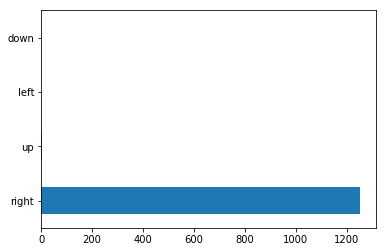

In [6]:
action_history = meta_results['action_history']
pd.Series(action_history).apply(lambda x: ACTIONS[x]).value_counts().plot(kind='barh')

play games

features:
* viz
    * include score board
    * |___| 
    
* return
    * #games
    * #games/second
    * longest game
    * shortest game
    * best game
    * worst game
    * num down, up, left, right
    * min reward, max reward
    * game rewards
    
* args
    * player {random, machine, human}
    * game size
    * play games




* view game 
* input:
    * game, rewards
* output viz

In [27]:
env.step

<bound method PyTetrisEnv.step of <tetris_api.PyTetrisEnv object at 0x119a42908>>

In [46]:
def viz_played_game(game_states, game_rewards,
                    view_delta=False, imshow=False, frame_delay=.02):
    """For replaying games, helpful for debugging and visualizing performance"""
    # Use `pretty_print_board` below.
    env = tetris_api.PyTetrisEnv()
    env.reset()
    
    num_moves = 0
    score = 0
    score_board = 'n: {}  score: {}'
    for state, reward in zip(game_states, game_rewards):
        clear_output(wait=True)
        num_moves += 1
        score += reward
        print(env.game.pretty_print_board(state))
        print(score_board.format(num_moves, score))
        time.sleep(frame_delay) 

def take_random_action():
    return np.argmax(np.random.uniform(0,1,4))

ACTIONS = {3: 'up', 2: 'right', 1: 'left', 0: 'down'}
done = False

env = tetris_api.PyTetrisEnv()
s_2D, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
states, rewards = [], []
while not done:
    print(1)
    states.append(s_2D)
    rewards.append(r)
    
    s_2D, r, done, _ = env.step(ACTIONS[take_random_action()]) 

viz_played_game(states, rewards)
states


|  1 1   |
|  1 1   |
|1 1     |
|1 1     |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|  1 1   |
|1 1     |
|1 1     |
______________________
n: 218  score: 0.6000000000000003


[array([[0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]), array([[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]), array([[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        

In [44]:
states

[array([[0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]), array([[0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]), array([[0, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        

In [8]:
def play_games(num_games, board_size, player, viz=None):
    """We want to be able to watch our trained agent play. Or a random agent. Or a human.
    Given a player, play num_games and return a bunch of stats about the games played. 
    """
    num_rows, num_cols = board_size
    env = tetris_api.PyTetrisEnv()
    
    # book keeping
    start_time = time.time()
    action_count = {'up': 0, 'down': 0, 'left': 0, 'right': 0}
    current_best_score = 0
    n_moves = 0
    games_rewards = []
    games_n_moves = []
    best_game_states = []
    best_game_rewards = []
    
    
    for game_id in range(num_games):
        # start new game
        s_2D, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
        s = tf_rl_utils.prepro(s_2D)
        prior_state = np.zeros_like(s)
        
        # keep track of high-level game info 
        reward_sum = 0
        game_n_moves = 0
        game_start_time = time.time()
        # keep track of move-level params, in case we want to viz
        game_states = [s_2D]
        game_rewards = [0]
        
        for move_num in range(max_ep):
            # determine action
            del_state = s - prior_state 
            action = player(del_state)

            # take action
            prior_state = s
            s_2D, r, done, _ = env.step(ACTIONS[action]) 
            
            # book keeping
            action_nm = ACTIONS[action]
            action_count[action_nm] = action_count[action_nm] + 1
            game_n_moves += 1
            reward_sum += r
            s = tf_rl_utils.prepro(s_2D)
            
            # for viz purposes
            game_states.append(s_2D)
            game_rewards.append(r)
            
            if done:
                n_moves += game_n_moves
                games_n_moves.append(game_n_moves)
                games_rewards.append(reward_sum)
                if reward_sum > current_best_score:
                    best_game_states.append(game_states)
                    best_game_rewards.append(game_rewards)
                if viz is not None:
                    viz_game(game_states, game_rewards, **viz)
                break
                
    # organize results and return
    total_time =  time.time() - start_time
    game_rewards = np.array(game_rewards)
    game_n_moves = np.array(game_n_moves)
    game_summary_dict = OrderedDict([('total_time', total_time),
                                     ('total_moves', n_moves),
                                    
                                     ('avg_moves_per_game', n_moves/float(num_games)),
                                     ('avg_reward_per_game', np.sum(games_rewards)/float(num_games)),
                                    
                                     ('indiv_game_rewards', [games_rewards]),
                                     ('indiv_game_n_moves', [games_n_moves]),
                                    
                                     ('max_moves', np.max(games_n_moves)),
                                     ('min_moves', np.min(games_n_moves)),
                                     ('best_game' , np.max(games_rewards)),
                                     ('worst_game', np.min(games_rewards)),
                                    
                                     ('total_down', action_count['down']),
                                     ('total_up', action_count['up']),
                                     ('total_left', action_count['left']),
                                     ('total_right', action_count['right']),
                                    
                                     ('best_game_states', [best_game_states]),
                                     ('best_game_rewards', [best_game_rewards])
                                    ])
    return pd.DataFrame(game_summary_dict, index = ['value']).T


    
def viz_game(game_states, game_rewards,
             view_delta=False, imshow=False, frame_delay=.02):
    """For replaying games, helpful for debugging
    and visualizing performance"""
    # for pretty board print
    env = tetris_api.PyTetrisEnv()
    env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
    
    # if we want to visualize delta
    prior_state = np.zeros_like(game_states[0])
    
    prior_states = [prior_state]*2
    
    
    num_moves = 0
    score = 0
    score_board = 'n: {}  score: {}'
    for state, reward in zip(game_states, game_rewards):
        del_state = state - prior_state
        clear_output(wait=True)
        num_moves += 1
        score += reward
        if imshow:
            prior_states.pop(0)
            prior_states.append(state)
            image = np.mean(prior_states, axis=0)
            plt.imshow(image)
            plt.show()
        elif view_delta:
            print(env.game.pretty_print_board(del_state))
        else:
            print(env.game.pretty_print_board(state))
        print(score_board.format(num_moves, score))
        time.sleep(frame_delay) 
        if imshow:
            plt.close()
        prior_state = state

def take_random_action(_):
    return np.random.uniform(0,1,4)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_path=model)
    rl_agent = pg_move(sess)
    agent = rl_agent
    viz={'view_delta': False, 'frame_delay': 0.02,'imshow': False}
    res = play_games(10, (num_rows, num_cols), agent, viz=None)

INFO:tensorflow:Restoring parameters from /Users/crawles/Documents/tetris-rl/models/tetris/fully_connected.ckpt


ValueError: Cannot feed value of shape (1, 64) for Tensor 'Placeholder:0', which has shape '(?, 320)'

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [86]:
rewards

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [115]:
np.random.dirichlet(np.ones(4),size=1)[0]

array([0.06843692, 0.31425438, 0.20869521, 0.40861349])

In [40]:
import tetris_api
import tf_rl_utils


def take_random_action(_):
    return np.random.dirichlet(np.ones(4),size=1)[0]

def _get_newest_state(flat_states, num_rows, num_cols):
    num_elements = num_rows * num_cols
    return [s[-num_elements:].reshape(num_rows, num_cols) for s in flat_states]
    
n_games = 10
env = tetris_api.PyTetrisEnv()
env.reset()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_path=model)
    rl_agent = pg_move(sess)
    agent = take_random_action
    for game in range(n_games):

        ep_history, meta_results = tf_rl_utils.play_game(env, agent, max_ep, num_rows, num_cols,
                                                         n_prior_states)



        ep_history = np.array(ep_history)
        nn_inputs  = ep_history[:,0]
        actions = ep_history[:,1]
        rewards = ep_history[:,2]
        states = _get_newest_state(nn_inputs, num_rows, num_cols)

        viz_game(states, rewards)


|        |
|        |
|        |
|        |
|        |
|        |
|        |
|1 1     |
|1 1     |
|        |
|        |
|        |
|    1 1 |
|    1 1 |
|  1 1   |
|  1 1   |
__________
n: 482  score: 3.4


KeyboardInterrupt: 

In [41]:
        viz_game(states, rewards)


|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|    1 1 |
|    1 1 |
|        |
|        |
|  1 1   |
|  1 1   |
__________
n: 449  score: 3.6


KeyboardInterrupt: 

## Old

In [25]:
def take_random_action(_):
    return np.random.randint(0,4)

class RL_Agent(object):
    
    def __init__(self, sess, output):
        self.sess = sess
        self.output = output
        
    def take_action(self, s):
        a_dist = self.sess.run(self.output, feed_dict={x: [s]})
        return chose_from_action_dist (a_dist)


def play_games(num_games, board_size, player, viz=None):
    """We want to be able to watch our trained agent play. Or a random agent. Or a human.
    Given a player, play num_games and return a bunch of stats about the games played. 
    """
    num_rows, num_cols = board_size
    env = tetris_api.PyTetrisEnv()
    
    # book keeping
    start_time = time.time()
    action_count = {'up': 0, 'down': 0, 'left': 0, 'right': 0}
    current_best_score = 0
    n_moves = 0
    games_rewards = []
    games_n_moves = []
    best_game_states = []
    best_game_rewards = []
    
    
    for game_id in range(num_games):
        # start new game
        s_2D, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
        s = tf_rl_utils.prepro(s_2D)
        prior_state = np.zeros_like(s)
        
        # keep track of high-level game info 
        reward_sum = 0
        game_n_moves = 0
        game_start_time = time.time()
        # keep track of move-level params, in case we want to viz
        game_states = [s_2D]
        game_rewards = [0]
        
        for move_num in range(max_ep):
            # determine action
            del_state = s - prior_state 
            action = player(del_state)

            # take action
            prior_state = s
            s_2D, r, done, _ = env.step(ACTIONS[action]) 
            
            # book keeping
            action_nm = ACTIONS[action]
            action_count[action_nm] = action_count[action_nm] + 1
            game_n_moves += 1
            reward_sum += r
            s = tf_rl_utils.prepro(s_2D)
            
            # for viz purposes
            game_states.append(s_2D)
            game_rewards.append(r)
            
            if done:
                n_moves += game_n_moves
                games_n_moves.append(game_n_moves)
                games_rewards.append(reward_sum)
                if reward_sum > current_best_score:
                    best_game_states.append(game_states)
                    best_game_rewards.append(game_rewards)
                if viz is not None:
                    viz_game(game_states, game_rewards, **viz)
                break
                
    # organize results and return
    total_time =  time.time() - start_time
    game_rewards = np.array(game_rewards)
    game_n_moves = np.array(game_n_moves)
    game_summary_dict = OrderedDict([('total_time', total_time),
                                     ('total_moves', n_moves),
                                    
                                     ('avg_moves_per_game', n_moves/float(num_games)),
                                     ('avg_reward_per_game', np.sum(games_rewards)/float(num_games)),
                                    
                                     ('indiv_game_rewards', [games_rewards]),
                                     ('indiv_game_n_moves', [games_n_moves]),
                                    
                                     ('max_moves', np.max(games_n_moves)),
                                     ('min_moves', np.min(games_n_moves)),
                                     ('best_game' , np.max(games_rewards)),
                                     ('worst_game', np.min(games_rewards)),
                                    
                                     ('total_down', action_count['down']),
                                     ('total_up', action_count['up']),
                                     ('total_left', action_count['left']),
                                     ('total_right', action_count['right']),
                                    
                                     ('best_game_states', [best_game_states]),
                                     ('best_game_rewards', [best_game_rewards])
                                    ])
    return pd.DataFrame(game_summary_dict, index = ['value']).T


    
def viz_game(game_states, game_rewards,
             view_delta=False, imshow=False, frame_delay=.02):
    """For replaying games, helpful for debugging
    and visualizing performance"""
    # for pretty board print
    env = tetris_api.PyTetrisEnv()
    env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
    
    # if we want to visualize delta
    prior_state = np.zeros_like(game_states[0])
    
    prior_states = [prior_state]*2
    
    
    num_moves = 0
    score = 0
    score_board = 'n: {}  score: {}'
    for state, reward in zip(game_states, game_rewards):
        del_state = state - prior_state
        clear_output(wait=True)
        num_moves += 1
        score += reward
        if imshow:
            prior_states.pop(0)
            prior_states.append(state)
            image = np.mean(prior_states, axis=0)
            plt.imshow(image)
            plt.show()
        elif view_delta:
            print(env.game.pretty_print_board(del_state))
        else:
            print(env.game.pretty_print_board(state))
        print(score_board.format(num_moves, score))
        time.sleep(frame_delay) 
        if imshow:
            plt.close()
        prior_state = state

rl_agent = RL_Agent(sess, output)
viz={'view_delta': False, 'frame_delay': 0.02,'imshow': False}
res = play_games(10, (num_rows, num_cols), take_random_action, viz=None)

,value
total_time,0.114357
total_moves,3127
avg_moves_per_game,312.7
avg_reward_per_game,27.56
indiv_game_rewards,"[37.79999999999998, -2.2, 17.6, -2.2, -2.2, 17..."
indiv_game_n_moves,"[382, 185, 249, 278, 240, 331, 338, 373, 318, ..."
max_moves,433
min_moves,185
best_game,96.8
worst_game,-2.2


In [115]:
def highest_piece(board, board_height=20):
    column_depths = board.argmax(axis=0)
    column_heights = board_height-column_depths[column_depths != 0]  # Exclude columns with no pieces.
    return column_heights.max()
highest_piece(env.game.board)
# env.game.number_of_cols
# env.game.board

10

In [128]:
env.reset()
env.game.board

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [179]:
states = [np.zeros([num_rows, num_cols])]*4
states
# env.game.board

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  

In [161]:
env.game.board = best_game_states[0][0]
print env.game.print_board()


|      1 1           |
|      1 1           |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          1 1       |
|          1 1       |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
______________________


In [154]:
rl_agent = RL_Agent(sess, output)
res = play_games(20, (num_rows, num_cols), rl_agent.take_action, viz=False)
res

,value
total_time,10.8638
total_moves,24066
avg_moves_per_game,1203.3
avg_reward_per_game,1
indiv_game_rewards,"[-1.0, -1.0, -1.0, -1.0, -1.0, 19.0, -1.0, -1...."
indiv_game_n_moves,"[1018, 1278, 1078, 1029, 1338, 1498, 1138, 111..."
max_moves,1771
min_moves,710
best_game,19
worst_game,-1


In [157]:
# watch best game
r = res.loc['indiv_game_rewards']
best_game_states = res.loc['best_game_states'][0]
best_game_rewards = res.loc['best_game_rewards'][0]

# viz_game(best_game_states, best_game_rewards)

In [107]:
best_game_states

<module 'tensorflow' from '/Users/crawles/anaconda/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Appendix
### View loss

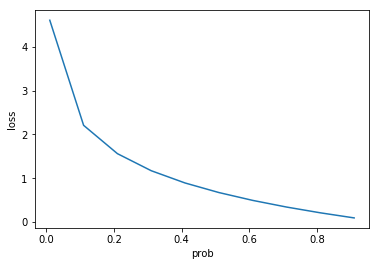

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

probs = np.arange(0.01,1,0.1)
reward = 1
loss = -reward*(np.log(probs))
plt.plot(probs, loss)
plt.ylabel('loss')
plt.xlabel('prob')

## Debugging TF gpu

In [20]:
# Creates a graph.
with tf.device('/gpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


## Save a model

In [ ]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

_X, _y = make_moons(n_samples=1000, noise = .1)

lr = RandomForestClassifier()
lr.fit(_X, _y)

_y_pred = lr.predict(_X)

df = pd.DataFrame(list(_X), columns=['f1','f2'])
df['label'] = _y
df['pred'] = _y_pred
ax1 = df.query('label==1').plot.scatter('f1', 'f2', c='blue')
df.query('label==0').plot.scatter('f1', 'f2', c='red', ax=ax1)
ax1.set_title('Labels')

ax = df.query('pred==1').plot.scatter('f1', 'f2', c='blue')
df.query('pred==0').plot.scatter('f1', 'f2', c='red', ax=ax)
ax.set_title('Labels')

In [41]:
np.hstack([_X, np.square(_X)])

array([[-0.34414253,  0.87279018,  0.11843408,  0.7617627 ],
       [-0.91493054,  0.06327654,  0.83709788,  0.00400392],
       [ 0.82959893,  0.22270176,  0.68823438,  0.04959607],
       ..., 
       [-0.12252092,  0.96687378,  0.01501137,  0.9348449 ],
       [ 1.59613813, -0.50831115,  2.54765694,  0.25838022],
       [ 0.62306261,  0.82527773,  0.38820702,  0.68108334]])

In [6]:
import os, datetime

model = os.path.join(os.path.join(os.getcwd(), 'models', 'lr_moons.ckpt'))


Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x000002E448401710>>
Traceback (most recent call last):
  File "C:\Users\Chris\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 694, in __del__
    if self._session is not None:
AttributeError: 'Session' object has no attribute '_session'


12.047449588775635


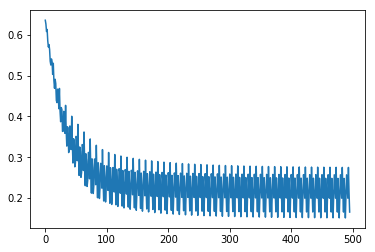

In [62]:
import agents



with tf.device("/GPU:0"):

    start = time.time()

    tf.reset_default_graph()

    # initial settings
    batch_size = 100
    epochs = 5000
    learning_rate = 0.001
    n_features = 2

    # layers
    n_hidden1 = 10
    n_hidden2 = 8

    moons_dataset = tf.data.Dataset.from_tensor_slices((_X, _y))
    moons_dataset = moons_dataset.batch(batch_size)
    moons_dataset = moons_dataset.repeat(epochs)
    iterator = moons_dataset.make_initializable_iterator()
    X, y = iterator.get_next()
    X = tf.cast(X, tf.float32)
    y = tf.cast(y, tf.int32)

    fully_connected_lr = agents.FullyConnected(tf.get_default_graph(), X, y, [n_hidden1, n_hidden2, 2], learning_rate)
    logits, loss, training_op = fully_connected_lr.logits, fully_connected_lr.loss, fully_connected_lr.training_op
    init = tf.global_variables_initializer()

    saver = tf.train.Saver()
    
    losses = []
    config = tf.ConfigProto(
            device_count = {'GPU': 0}
        )
    with tf.Session(config=config) as sess:
        init.run()
        sess.run(iterator.initializer)
        i = 0
        while True:
            i += 1
            try:
                sess.run(training_op)
                if i % 100 == 1:
                    losses.append(sess.run(loss))
            except tf.errors.OutOfRangeError:
                break
#         mydir = os.path.join(os.path.join(os.getcwd(), 'models'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        save_path = saver.save(sess, model)
        pred = sess.run(tf.nn.softmax(logits), feed_dict={X: _X, y: _y})
    print(time.time() - start)
    plt.plot(losses)

In [67]:
model

'C:\\Users\\Chris\\Google Drive\\notebooks\\tetris-rl\\models\\lr_moons.ckpt'

In [7]:
import agents
tf.reset_default_graph()


with tf.Session() as sess:

    # initial settings
    batch_size = 100
    epochs = 5000
    learning_rate = 0.001
    n_features = 2

    # layers
    n_hidden1 = 10
    n_hidden2 = 8

    moons_dataset = tf.data.Dataset.from_tensor_slices((_X, _y))
    moons_dataset = moons_dataset.batch(batch_size)
    moons_dataset = moons_dataset.repeat(epochs)
    iterator = moons_dataset.make_initializable_iterator()
    X, y = iterator.get_next()
    X = tf.cast(X, tf.float32)
    y = tf.cast(y, tf.int32)

    fully_connected_lr = agents.FullyConnected(tf.get_default_graph(), X, y, [n_hidden1, n_hidden2, 2], learning_rate)
    logits, loss, training_op = fully_connected_lr.logits, fully_connected_lr.loss, fully_connected_lr.training_op
    init = tf.global_variables_initializer()

    saver = tf.train.Saver()
    
    saver.restore(sess, save_path=model)
    pred = sess.run(tf.nn.softmax(logits), feed_dict={X: _X, y: _y})


INFO:tensorflow:Restoring parameters from C:\Users\Chris\Google Drive\notebooks\tetris-rl\models\lr_moons.ckpt


Text(0.5,1,'Data')

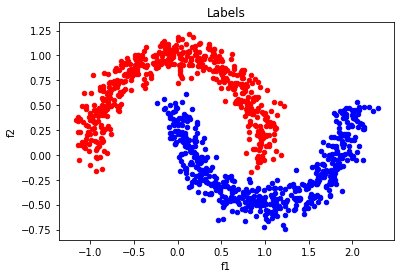

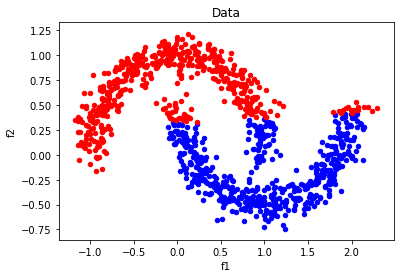

In [8]:
import numpy as np
y_pred = np.argmax(pred, axis=1)

df = pd.DataFrame(list(_X), columns=['f1','f2'])
df['label'] = _y
df['pred'] = y_pred
ax1 = df.query('label==1').plot.scatter('f1', 'f2', c='blue')
df.query('label==0').plot.scatter('f1', 'f2', c='red', ax=ax1)
ax1.set_title('Labels')

ax = df.query('pred==1').plot.scatter('f1', 'f2', c='blue')
df.query('pred==0').plot.scatter('f1', 'f2', c='red', ax=ax)
ax.set_title('Data')

In [105]:
tf.reset_default_graph()

y = tf.placeholder(tf.int32)
logits = tf.placeholder(tf.float32)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(cross_entropy, feed_dict={y: _y[:, None], logits: _X[:,1, None]})
r

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0